# Get data

In [152]:
import hopsworks
from hsfs.feature import Feature
from datetime import date

project = hopsworks.login()
fs = project.get_feature_store()
acm_papers_fg = fs.get_feature_group("acm_papers", 1)
query = fs.get_feature_group("acm_papers", 1)
df = query.filter(
    (Feature("publication_date") >= date(2023, 1, 1))
    & (Feature("publication_date") <= date(2023, 12, 31))
).read(read_options={"use_hive": True})
df

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196758
Connected. Call `.close()` to terminate connection gracefully.


Finished: Reading data from Hopsworks, using Hive (5.24s) 


,citation,abstract,publication_date
0,"@inproceedings{10.1007/978-3-031-23585-6_7,\na...",Abstract\nWith the continuous development of i...,2023-01-01
1,"@inproceedings{10.1007/978-3-031-23198-8_3,\na...",Abstract\nInternational Classification of Dise...,2023-01-01
2,"@inproceedings{10.1007/978-3-031-23028-8_26,\n...",Abstract\nThe point cloud is a 3D geometric da...,2023-01-01
3,"@inproceedings{10.1007/978-3-031-23028-8_25,\n...",Abstract\nTables are widely used in documents ...,2023-01-01
4,"@inproceedings{10.1007/978-3-031-23028-8_21,\n...","Abstract\nIn Multi-Label Classification, utili...",2023-01-01
...,...,...,...
1013,"@inproceedings{10.1145/3620679.3620720,\nautho...",A fit person who is health conscious always co...,2023-12-19
1014,"@inproceedings{10.1145/3627341.3630366,\nautho...",This paper introduces a binary classification ...,2023-12-15
1015,"@inproceedings{10.1145/3617233.3617267,\nautho...",Glaciers play a critical role in the Earth’s c...,2023-12-30
1016,"@article{10.1145/3638353,\nauthor = {Li, Ximin...",Text Classification (TC) is a fundamental task...,2023-12-22


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   citation          1018 non-null   object
 1   abstract          1018 non-null   object
 2   publication_date  1018 non-null   object
dtypes: object(3)
memory usage: 24.0+ KB


In [154]:
# Remove duplicates
df_unique = df.drop_duplicates(subset=["abstract"], keep="first")

# Remove "Abstract\n" from the beginning of the abstract, it's a scraping error
scraping_error = "Abstract\n"
df_unique["abstract"] = df_unique["abstract"].str.replace(f'^{scraping_error}', "", regex=True)

df_unique

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,citation,abstract,publication_date
0,"@inproceedings{10.1007/978-3-031-23585-6_7,\na...",With the continuous development of information...,2023-01-01
1,"@inproceedings{10.1007/978-3-031-23198-8_3,\na...",International Classification of Disease (ICD) ...,2023-01-01
2,"@inproceedings{10.1007/978-3-031-23028-8_26,\n...",The point cloud is a 3D geometric data of irre...,2023-01-01
3,"@inproceedings{10.1007/978-3-031-23028-8_25,\n...",Tables are widely used in documents because of...,2023-01-01
4,"@inproceedings{10.1007/978-3-031-23028-8_21,\n...","In Multi-Label Classification, utilizing label...",2023-01-01
...,...,...,...
995,"@inproceedings{10.1145/3615900.3628769,\nautho...",Reducing traffic accidents is a crucial global...,2023-11-29
998,"@inproceedings{10.1007/978-3-031-48312-7_43,\n...",This paper presents an automatic dialect ident...,2023-11-29
1002,"@inproceedings{10.1007/978-3-031-48309-7_37,\n...",The article provides a description of the most...,2023-11-29
1006,"@inproceedings{10.1007/978-3-031-48312-7_33,\n...",Classification of normal vs. pathological infa...,2023-11-29


## Clean data

In [98]:
import subprocess

command = "python -m spacy download en_core_web_trf"
subprocess.run(command.split())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.3 MB/s eta 0:00:0000:0100:03
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


CompletedProcess(args=['python', '-m', 'spacy', 'download', 'en_core_web_trf'], returncode=0)

In [155]:
from spacy.lang.en import STOP_WORDS
import string

punctuations = string.punctuation
stop_words = list(STOP_WORDS)
stop_words[:10]

['beforehand',
 'however',
 'against',
 'how',
 'moreover',
 'move',
 'only',
 'whenever',
 'but',
 'elsewhere']

In [156]:
from custom_stop_words import custom_stop_words

for word in custom_stop_words:
    if word not in stop_words:
        stop_words.append(word)

In [157]:
import en_core_web_trf

parser = en_core_web_trf.load(disable=["tagger", "ner"])


def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [
        word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_
        for word in mytokens
    ]
    mytokens = [
        word for word in mytokens if word not in stop_words and word not in punctuations
    ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


# Show progress bar
from tqdm import tqdm

tqdm.pandas()

df_unique["abstract_clean"] = df_unique["abstract"].progress_apply(spacy_tokenizer)
df_unique["abstract_clean"]

100%|██████████| 955/955 [02:05<00:00,  7.60it/s]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0       continuous development information technology ...
1       international disease icd coding assign standa...
2       point cloud 3d geometric irregular format resu...
3       tables widely documents compact structured rep...
4       multi utilizing relationship key improve space...
                              ...                        
995     reducing traffic accidents crucial global publ...
998     presents automatic dialect identification ao m...
1002    article provides description frequent bigrams ...
1006    normal vs. pathological infant cry socially re...
1008    automatic detection mental disorders mainly pe...
Name: abstract_clean, Length: 955, dtype: object

# Vectorization

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer


def vectorize(text, max_features_count):
    vectorizer = TfidfVectorizer(max_features=max_features_count)
    X = vectorizer.fit_transform(text)
    return X


text = df_unique["abstract_clean"].values
max_features_count = 2**12 # 4096 (just a big initial number, will be reduced later)
X = vectorize(text, max_features_count)

# print the shape of X
X.shape

(955, 4096)

# Principle Component Analysis (PCA)

In [159]:
from sklearn.decomposition import PCA

# Reduce the dimensionality of the TF-IDF matrix while retaining 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(955, 797)

# K-Means Clustering

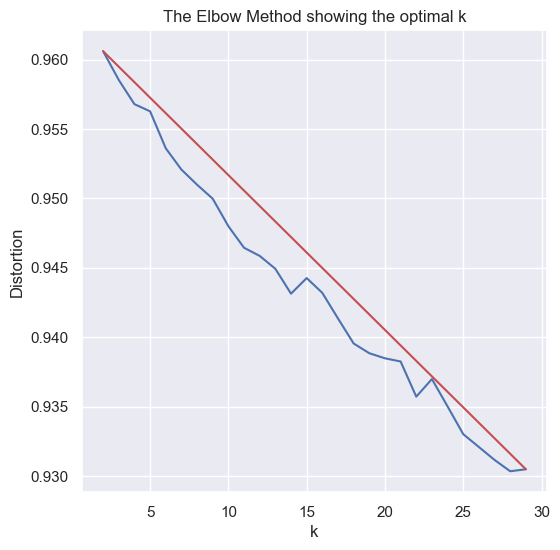

In [160]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    distortions.append(
        sum(np.min(cdist(X_reduced, k_means.cluster_centers_, "euclidean"), axis=1))
        / X.shape[0]
    )


from matplotlib import pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, "b-")
plt.plot(X_line, Y_line, "r")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing the optimal k")
plt.show()

In [161]:
k =11
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_unique["cluster"] = y_pred

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Dimensionality Reduction with t-SNE

In [162]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50, random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 955 samples in 0.002s...
[t-SNE] Computed neighbors for 955 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 955 / 955
[t-SNE] Mean sigma: 0.282934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.730259
[t-SNE] KL divergence after 1000 iterations: 1.712544


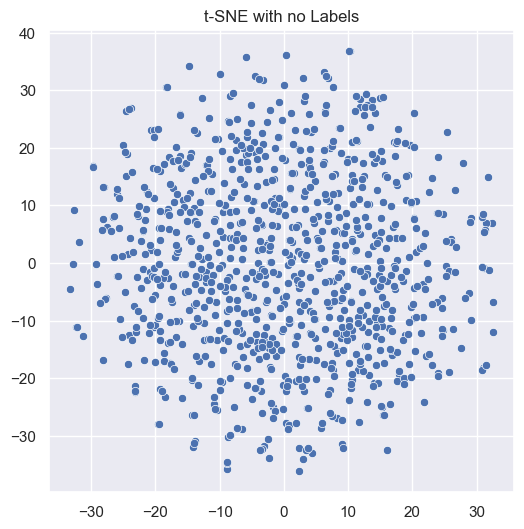

In [163]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(6,6)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
# plt.savefig("t-sne_covid19.png")
plt.show()

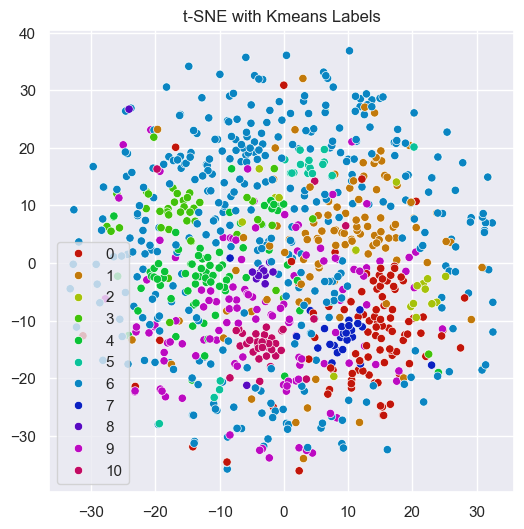

In [164]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(6,6)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()

# Topic Modeling on Each Cluster

In [165]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = []
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(
        CountVectorizer(
            min_df=5,
            max_df=0.9,
            stop_words="english",
            lowercase=True,
            token_pattern="[a-zA-Z-][a-zA-Z-]{2,}",
        )
    )

vectorized_data = []
for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(
            cvec.fit_transform(df_unique.loc[df_unique["cluster"] == current_cluster, "abstract_clean"])
        )
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

vectorized_data[0].shape

(100, 364)

Latent Dirichlet Allocation (LDA) is a model used for topic modeling. It assumes that documents are made up of a few main topics, and each word in a document is associated with one of these topics. LDA is a generative probabilistic model, meaning that it assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.

In [166]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = k

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(
        n_components=NUM_TOPICS_PER_CLUSTER,
        max_iter=10,
        learning_method="online",
        verbose=False,
        random_state=42,
    )
    lda_models.append(lda)

clusters_lda_data = []
for current_cluster, lda in enumerate(lda_models):
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))


# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []

    for _, topic in enumerate(model.components_):
        words = [
            (vectorizer.get_feature_names_out()[i], topic[i])
            for i in topic.argsort()[: -top_n - 1 : -1]
        ]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key=lambda x: x[1])
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values


all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

# Print out topics for each cluster
for ii in range(0, k):
    if vectorized_data[ii] != None:
        print("Cluster " + str(ii) + " topics:")
        print(all_keywords[ii])

Cluster 0 topics:
['text', 'information', 'nodes', 'corpus', 'pooling', 'knowledge', 'language', 'graph', 'relation', 'novel', 'shot', 'multi', 'high', 'algorithms', 'natural', 'sentence', 'syntactic', 'content', 'research', 'prior']
Cluster 1 topics:
['neural', 'level', 'images', 'deep', 'cnn', 'information', 'attention', 'image', 'activation', 'proposed', 'order', 'series', 'time', 'problem', 'support', 'architectures', 'representations', 'module', 'parameters', 'recognition', 'augmentation', 'effective', 'solution', 'good', 'disease']
Cluster 2 topics:
['categories', 'unknown', 'novel', 'proposed', 'existing', 'recognition', 'known', 'open', 'identification', 'detection', 'classify', 'identify', 'different', 'information', 'effective', 'state', 'work', 'achieve', 'unlabeled', 'present']
Cluster 3 topics:
['smote', 'minority', 'majority', 'oversampling', 'imbalance', 'problem', 'new', 'framework', 'terms', 'different', 'process', 'novel', 'important', 'study', 'issue', 'proposed', 'e

# Save results

### Save DataFrame with features, cluster labels and 2D coordinates

In [29]:
# Create a new DataFrame with the cluster information
df_output = df_unique.copy()

# Add 2D embedding information
df_output["x_coord"] = X_embedded[:, 0]
df_output["y_coord"] = X_embedded[:, 1]

# Save the DataFrame to Hopsworks
output_fg = fs.get_or_create_feature_group(
    "acm_papers_clustered_last_year",
    version=1,
    description="The output of the clustering of the ACM papers",
    primary_key=["citation"],
    event_time="publication_date",
)
output_fg.insert(df_output, overwrite=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/196758/fs/196677/fg/415069


Uploading Dataframe: 100.00% |██████████| Rows 958/958 | Elapsed Time: 00:09 | Remaining Time: 00:00


Launching job: acm_papers_clustered_last_year_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/196758/jobs/named/acm_papers_clustered_last_year_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2b6c471d0>, None)

### Save keywords for each cluster

In [30]:
import pandas as pd

keywords_strings = []
for ii in all_keywords:
    keywords_strings.append(", ".join(ii))
# DataFrame with cluster number as primary key
df_keywords = pd.DataFrame(
    {"cluster": range(0, k), "keywords": keywords_strings}
)

# Upload to Hopsworks
keywords_fg = fs.get_or_create_feature_group(
    "acm_papers_cluster_keywords_last_year",
    version=1,
    description="The keywords for each cluster",
    primary_key=["cluster"],
)
keywords_fg.insert(df_keywords, overwrite=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/196758/fs/196677/fg/414058


Uploading Dataframe: 100.00% |██████████| Rows 11/11 | Elapsed Time: 00:06 | Remaining Time: 00:00


Launching job: acm_papers_cluster_keywords_last_year_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/196758/jobs/named/acm_papers_cluster_keywords_last_year_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2b6c60c90>, None)